In [1]:
import local_models.local_models as lm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import local_models.loggin
import local_models.TLS_models
from local_models.TLS_models import LinearRegression, QuadraticRegression, SphericalRegression, LinearODR

logger = logging.getLogger(__name__)

reload(local_models.local_models)
reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [2]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [3]:
K=3
n = 3
SEED = 1
np.random.seed(SEED)
KERNEL=lm.TriCubeKernel
small_data, c = np.random.random(size=(n,2)), np.zeros(shape=(n,))

In [4]:
project_dir = "../data/smalldata/n{}_seed{}_ktricube_02".format(str(n).rjust(5,"0"), str(SEED).rjust(5,"0"))
os.makedirs(project_dir, exist_ok=1)

In [5]:
small_data.shape

(3, 2)

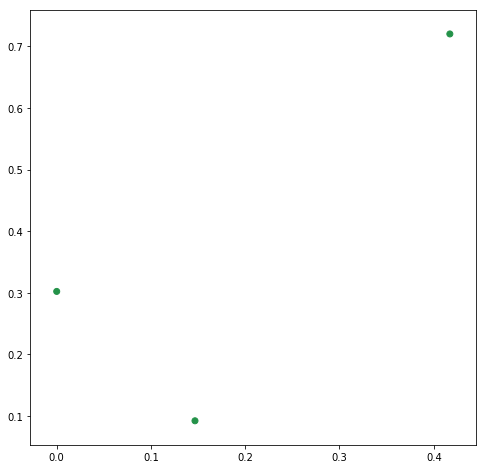

In [6]:
plt.scatter(small_data[:,0], small_data[:,1],c=cmap(c))
plt.show()

In [7]:
linear_models = lm.LocalModels(LinearODR())
linear_models.fit(small_data)

In [8]:
def get_global_grid(x, outside_range_pct=0.1, n_steps=100):
    '''outside_range_pct and n_steps can be a float or a 1d array same len as x.shape[1]'''
    min_x, max_x = np.min(x, axis=0), np.max(x, axis=0)
    x_range = max_x - min_x
    how_much_to_include_outside_range =  outside_range_pct*x_range
    x_ranges = np.stack((min_x - how_much_to_include_outside_range, max_x + how_much_to_include_outside_range))
    x_step = ((x_ranges[1] - x_ranges[0])/n_steps)
    grid_limits = tuple(map(lambda i: slice(x_ranges[0,i], x_ranges[1,i], x_step[i]), range(x_ranges.shape[1])))
    g = np.mgrid[grid_limits]
    return g

class Grid2Vec(object):
    def fit(self, x):
        self.original_data_like_shape = [-1] + list(x.shape[1:])
        return self
    def transform(self, x):
        return np.vstack(map(np.ravel, x)).T
    def fit_transform(self, x):
        return self.fit(x).transform(x)
    def inverse_transform(self, x):
        return x.T.reshape(self.original_data_like_shape)

def local_model_projection_transformation(local_models, x, local_model_params=None, **local_model_params_kwargs):
    '''pass in local_model_params if you've already computed them'''
    model_clone = sklearn.base.clone(local_models.model)
    projected_x = np.zeros(x.shape)
    if local_model_params is None:
        local_model_params = lm.transform(x, **local_model_params_kwargs)
    for i in range(x.shape[0]):
        lm.set_learned_param_vector(model_clone, local_model_params[i])
        projected_x[i] = model_clone.project(x[i])
    return projected_x

def perp2d(v):
    a,b = v
    return np.array((-b,a))/np.linalg.norm([a,b])

def linear_space(center, normal, span):
    return np.einsum("i,j->ij", span, perp2d(normal)) + center

def linear_project(pt, normal):
    lr = LinearODR()
    lm.set_learned_param_vector(lr, normal)
    return lr.project(pt)

def linear_project_vectorized(pts, normals):
    n_dot_n = np.einsum('ij,ij->i',normals,normals)
    x_dot_n = np.einsum('ij,ij->i',pts,normals)
    return ((1-x_dot_n)/n_dot_n).reshape((-1,1))*normals

def sublinear_project_vectorized(pts, orthonormal_basis, mean=0):
    #first, shift everything by the mean
    x = pts - mean
    #now the plane passes through the origin, and we can project onto the eigenspace directly
    projection = np.einsum('ij,kj->ki',orthonormal_basis,x).dot(orthonormal_basis)
    #now shift back
    return projection + mean

def linear_project_vectorwise(pts, orthonormal_basis, mean=0):
    x = x-mean
    projections = np.einsum('ij,kj->kij',orthonormal_basis,x)
    return projections + mean


def imgs2video(glob, outfile, framerate=50):
    import subprocess
    args = "ffmpeg -r {} -pattern_type glob -i \"{}\" -c:v libx264 -vf \"fps=25,format=yuv420p\" {} -y".format(
        framerate, glob, outfile)
    print(args)
    p = subprocess.Popen(args, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    output, err = p.communicate()
    print(subprocess.list2cmdline(args), output, err)
    
def projection_length(x,linear_models,k,weighted,distance_transform):
    pt_params = linear_models.transform(x.reshape((1,-1)), k=k, weighted=weighted, distance_transform=distance_transform)
    l = LinearODR()
    l.coef_ = pt_params[0]
    return np.linalg.norm(l.project(x))

In [9]:
def make_local_odr_lines_animation(linear_models, data, c, pth, bandwidths, range_pct=0.1, kernel=lm.TriCubeKernel):
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=len(bandwidths), tag="odr_lines")
    min_nm, max_nm = np.min(data, axis=0), np.max(data, axis=0)
    nm_range = max_nm - min_nm
    how_much_to_include_outside_range =  range_pct*nm_range
    nm_ranges = np.stack((min_nm - how_much_to_include_outside_range, max_nm + how_much_to_include_outside_range))
    
    os.makedirs(pth, exist_ok=1)
    for bandwidth in bandwidths:
        with timelog:
            print(bandwidth)
            kernel_cb = kernel(bandwidth=bandwidth)
            figure = plt.figure()
            linear_params_cb = linear_models.transform(data,r=kernel_cb.support_radius(),weighted=True,distance_transform=kernel_cb, neighbor_beta0s=True)
            span = np.linspace(-0.2,0.2,10)
            for i in range(data.shape[0]):
                pt = linear_project_vectorized(data[i], linear_params_cb[i]) + data[i]
                line = linear_space(pt, linear_params_cb[i], span)
                plt.plot(line[:,0], line[:,1])
            plt.scatter(data[:,0], data[:,1],c=cmap(c))
            plt.title(str(bandwidth))
            plt.xlim(nm_ranges[:,0])
            plt.ylim(nm_ranges[:,1])

            plt.savefig(os.path.join(pth, "bandwidth_{:010.5f}.png".format(bandwidth)))

0.03
0.0435
0.057
0.07050000000000001
0.084
0.0975
0.11100000000000002
0.12450000000000001
0.138
0.15150000000000002
0.165
0.17850000000000002
0.19200000000000003
0.20550000000000002
0.21900000000000003
0.2325
0.24600000000000002
0.25950000000000006
0.273
0.2865
0.3
0.33499999999999996
0.37
0.40499999999999997
0.43999999999999995
0.475
0.51
0.5449999999999999
0.58
0.615
0.6499999999999999
0.6849999999999999
0.72
0.7549999999999999
0.7899999999999999
0.825
0.8599999999999999
0.895
0.9299999999999999
0.9649999999999999
1.0
1.2
1.4
1.6
1.8
2.0
2.2
2.4000000000000004
2.6
2.8
3.0
3.2
3.4000000000000004
3.6
3.8000000000000003
4.0
4.2
4.4
4.6
4.800000000000001


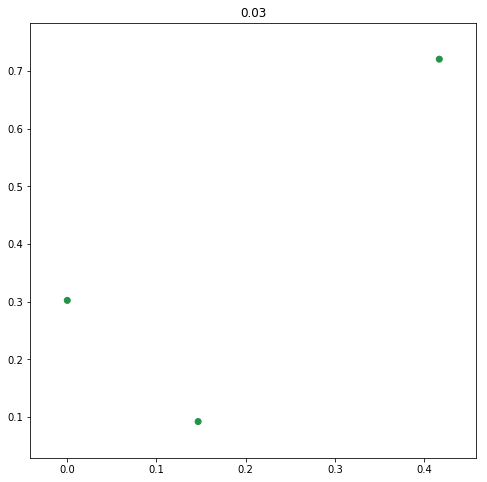

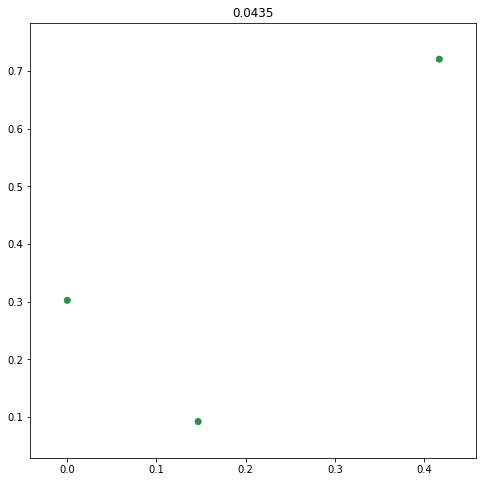

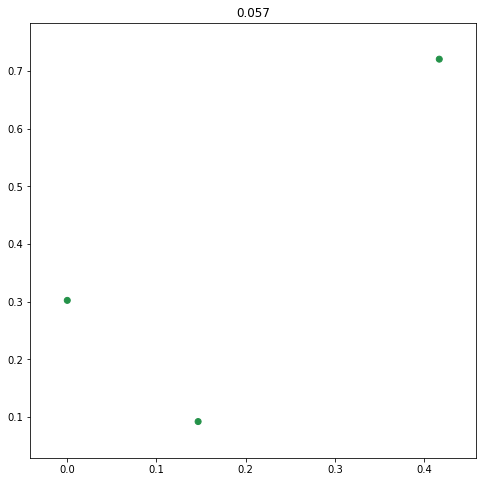

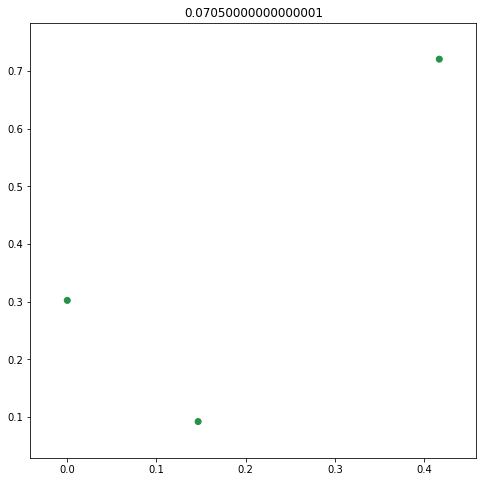

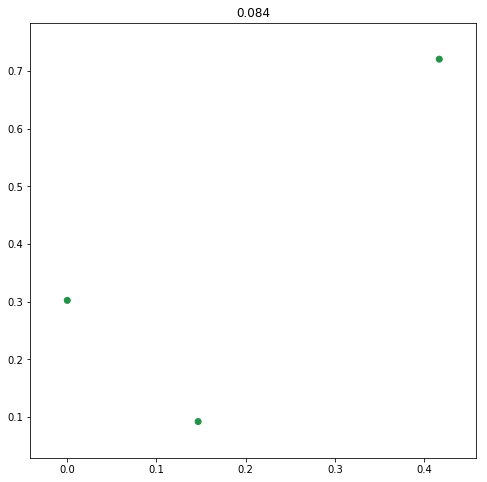

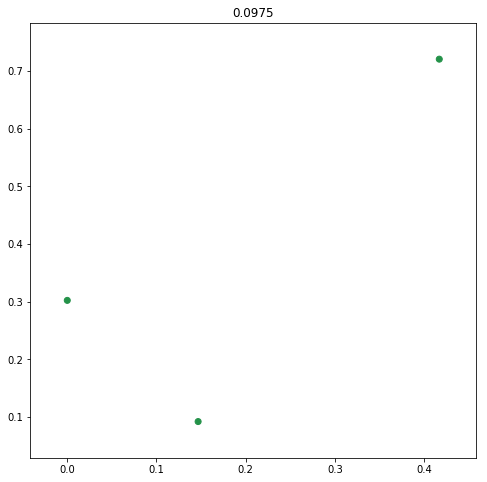

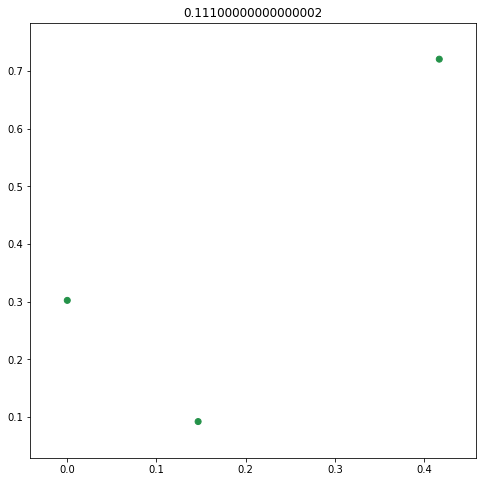

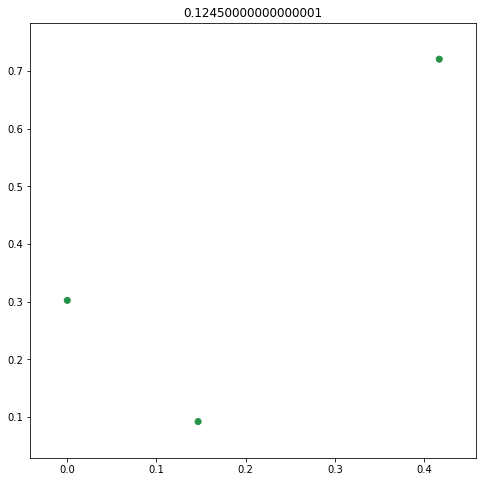

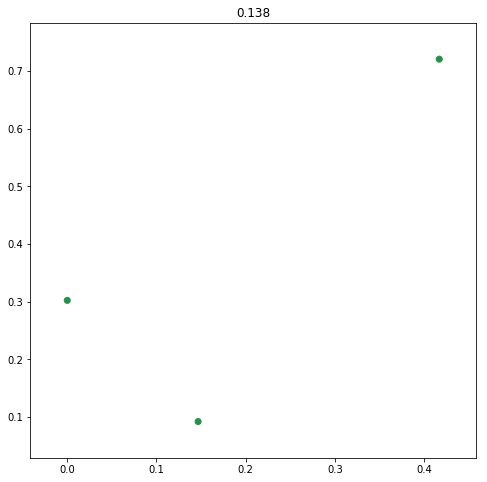

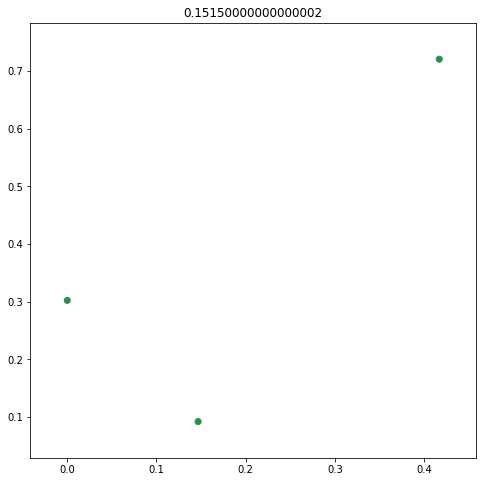

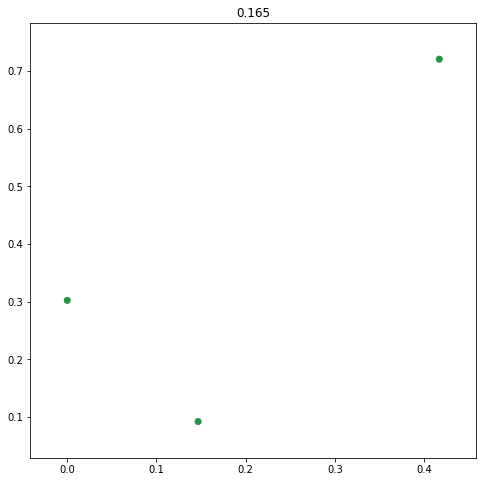

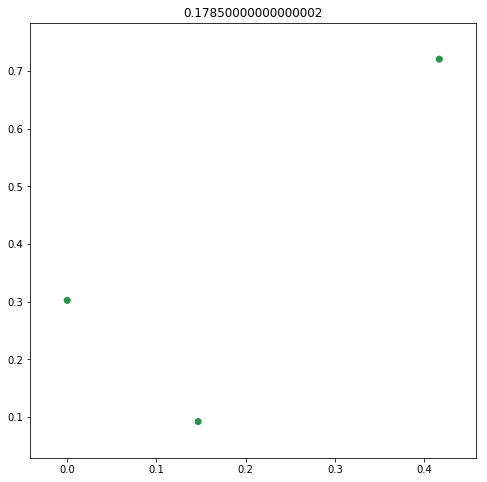

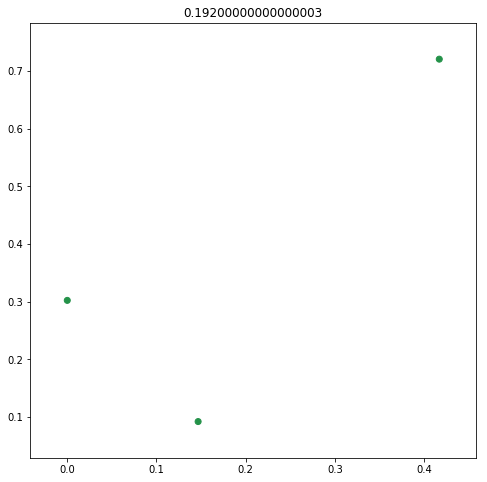

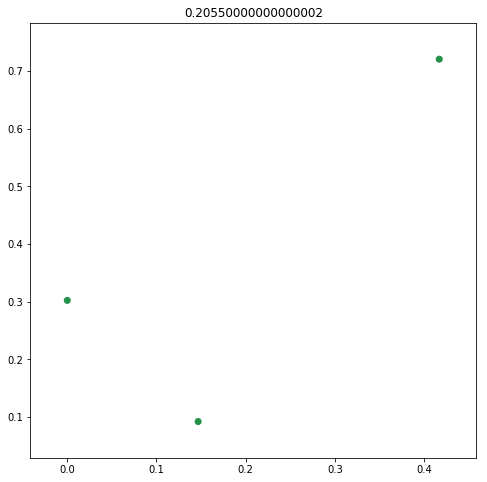

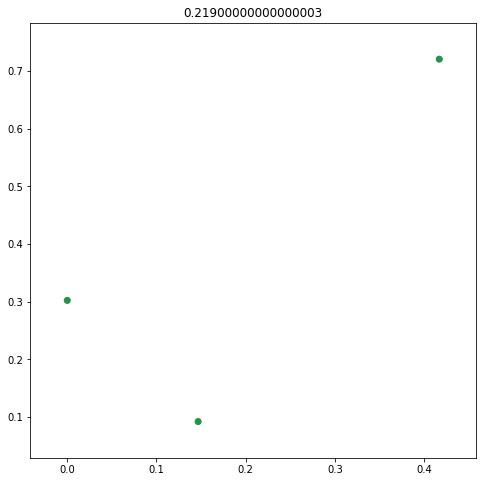

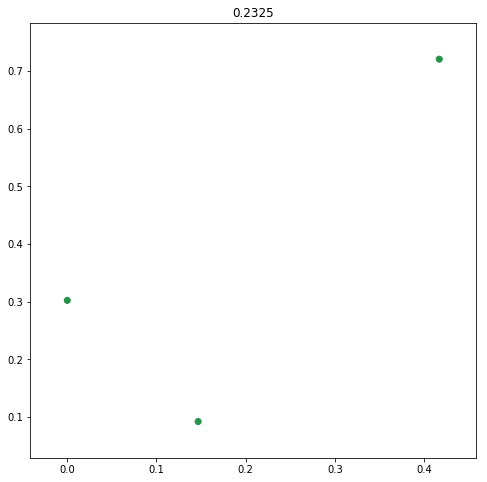

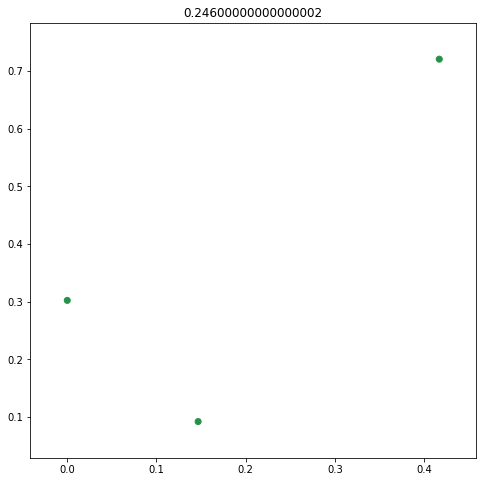

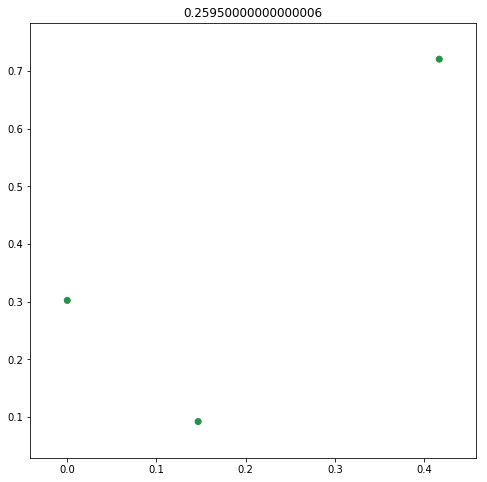

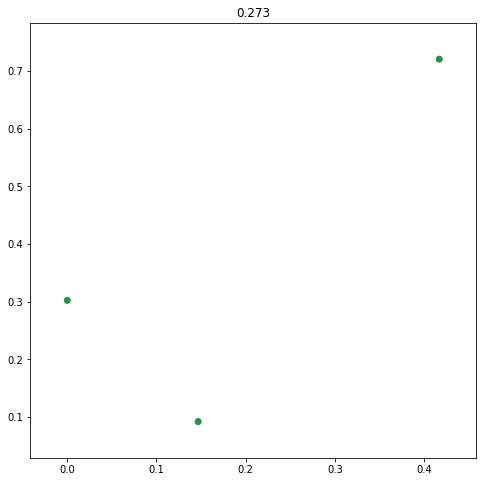

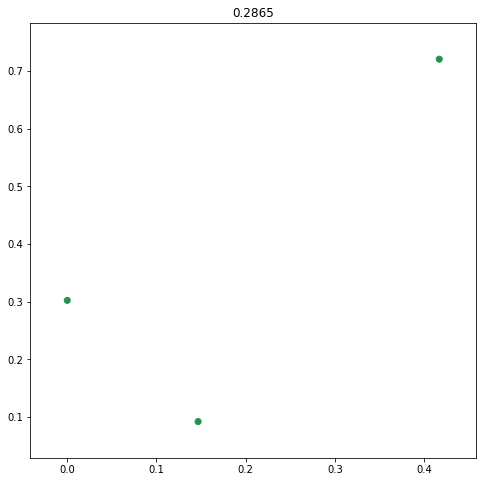

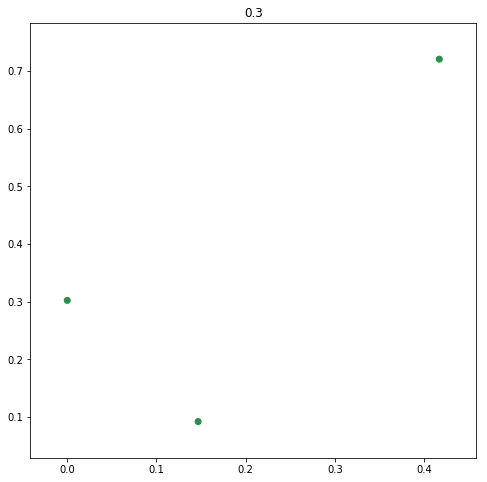

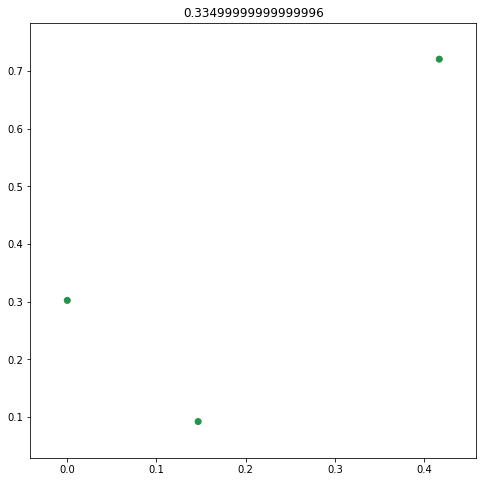

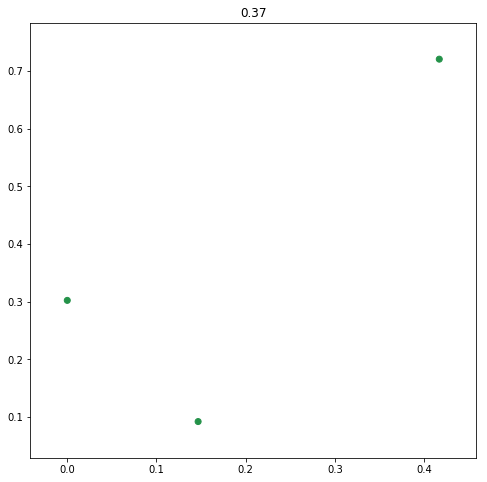

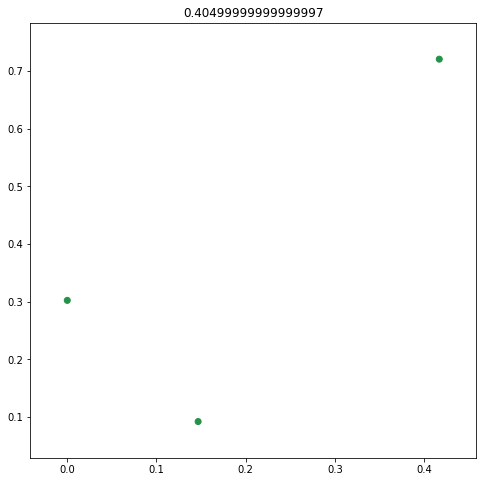

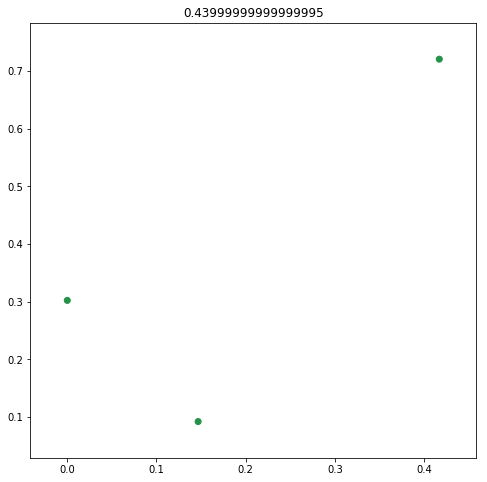

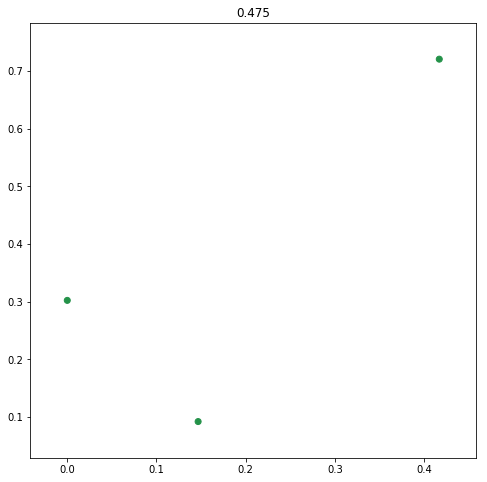

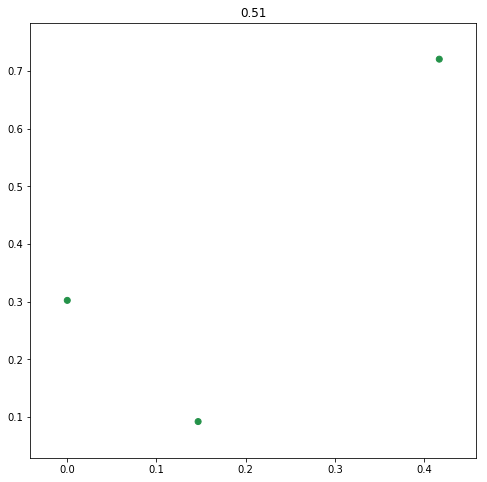

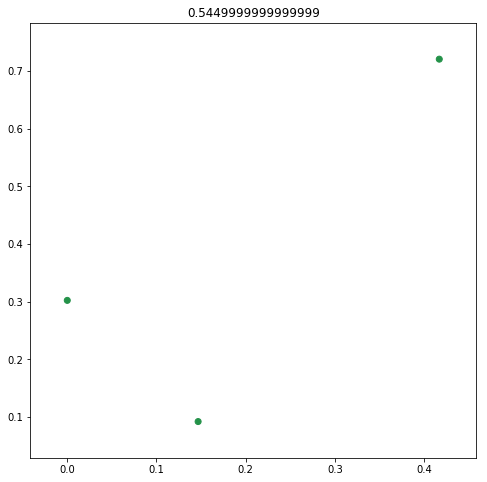

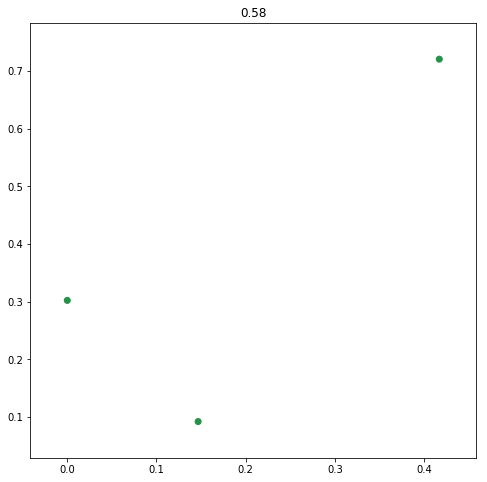

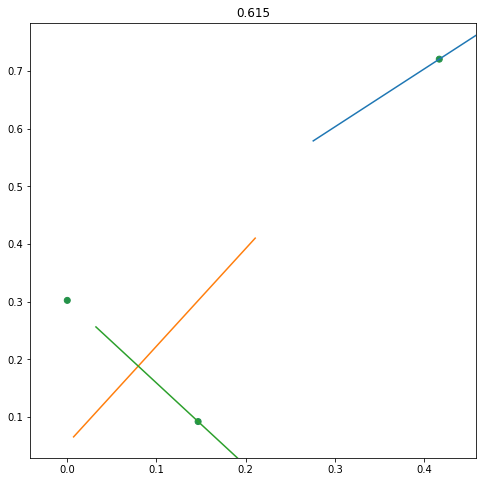

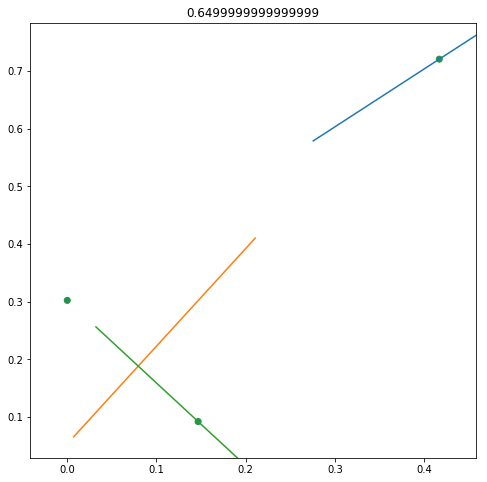

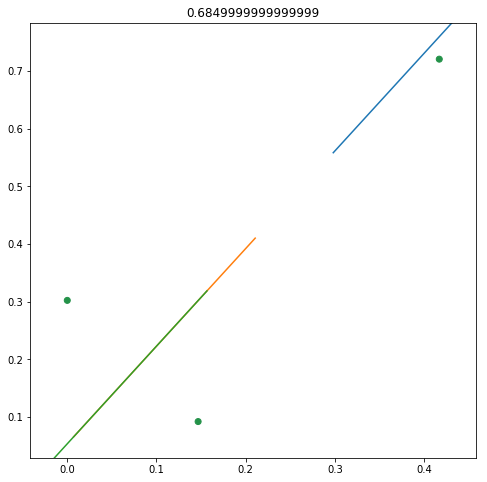

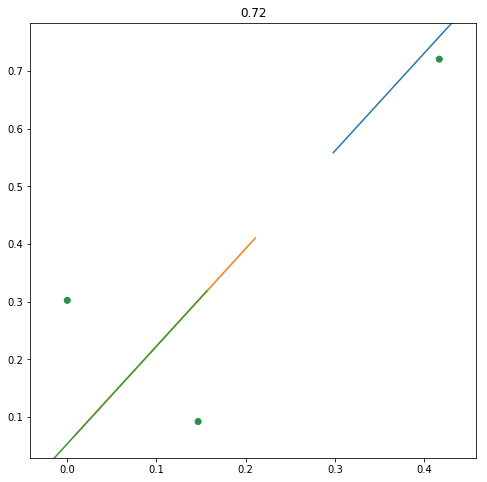

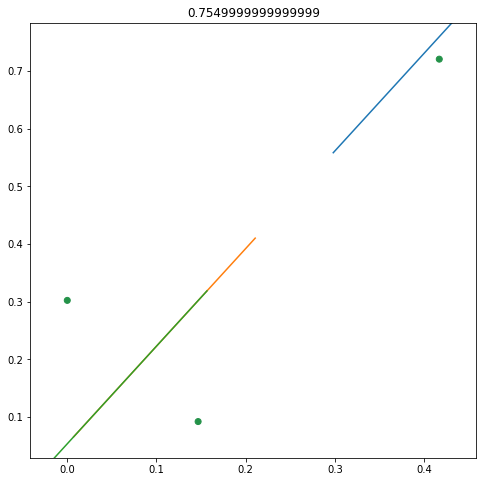

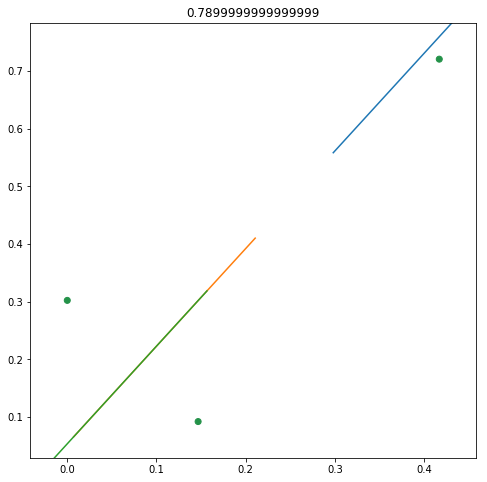

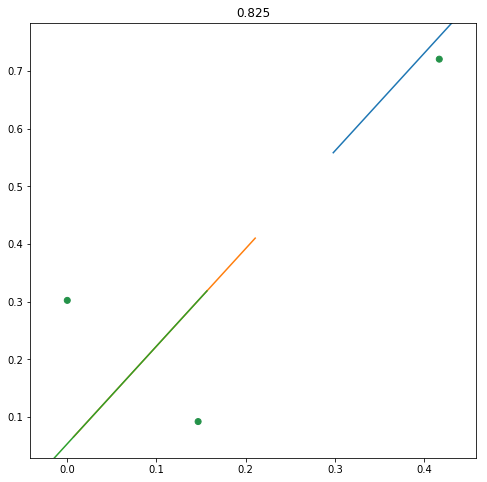

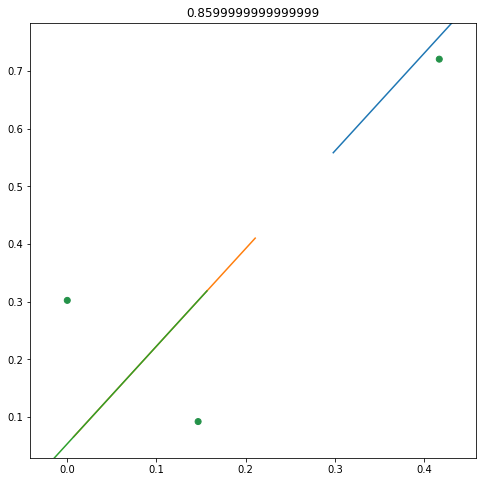

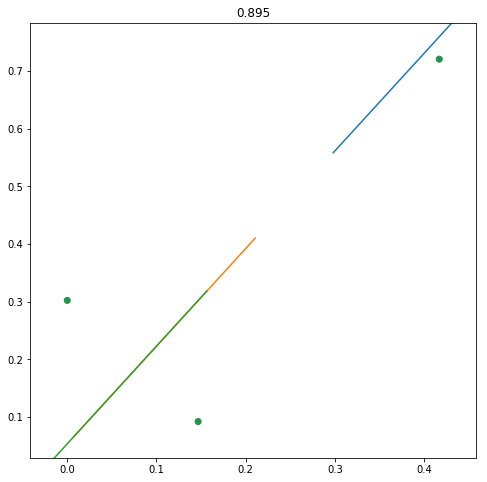

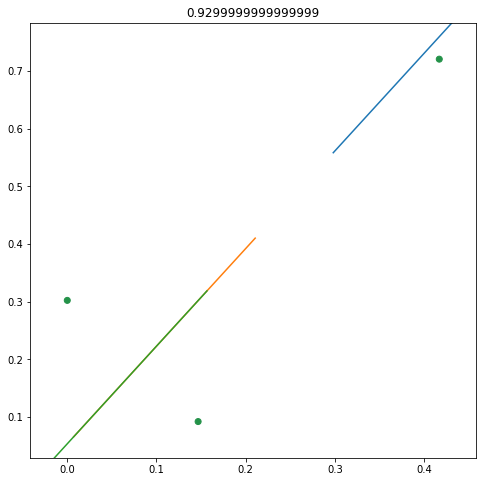

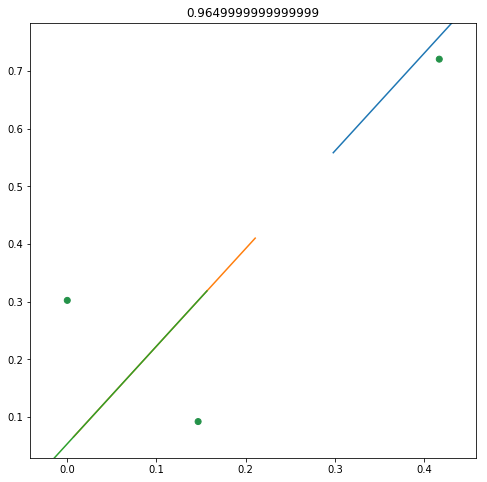

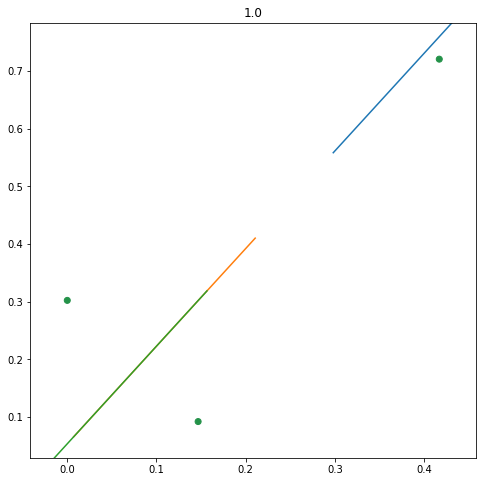

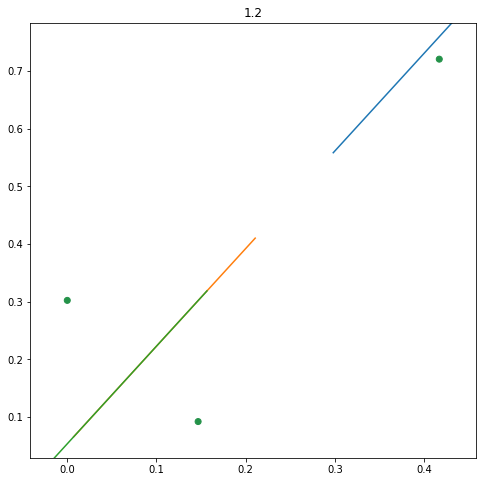

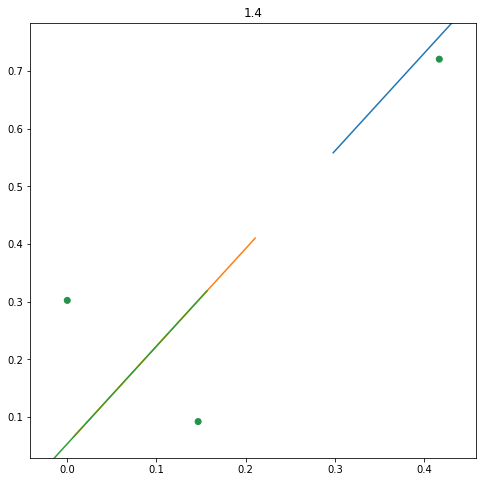

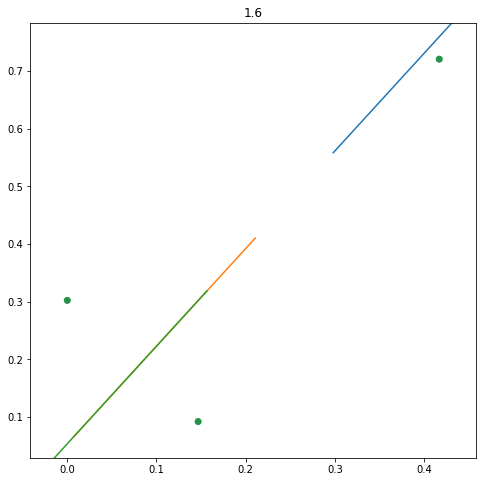

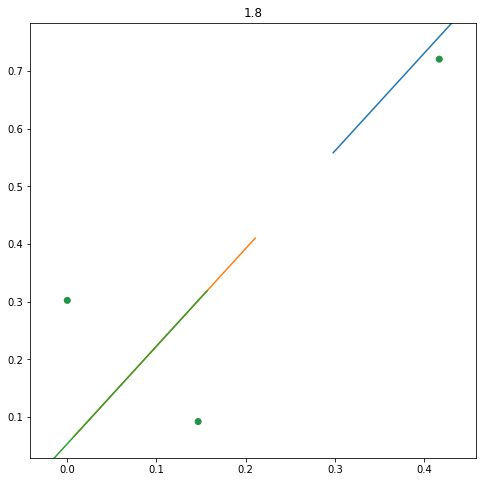

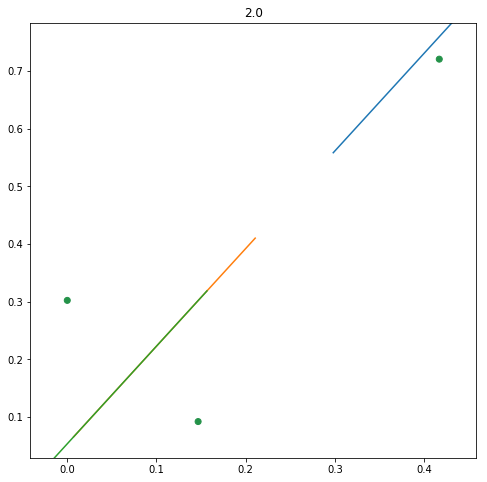

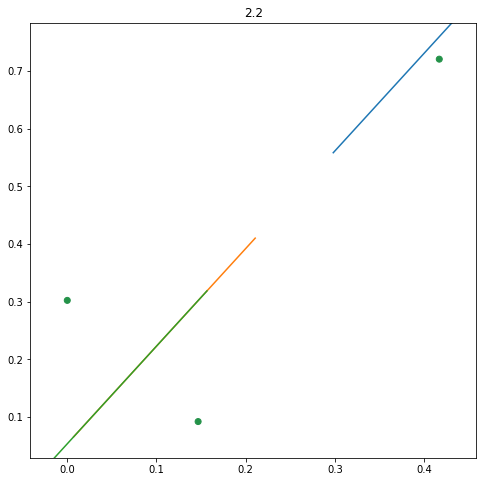

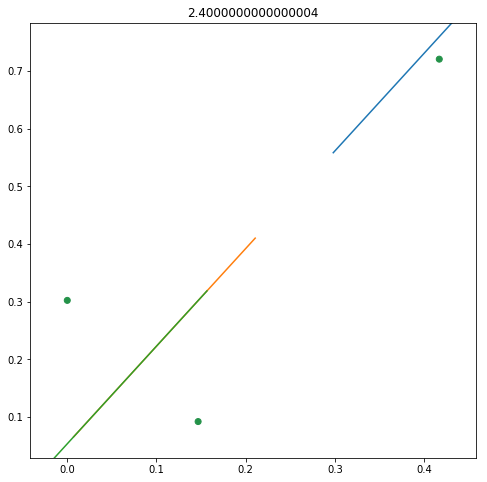

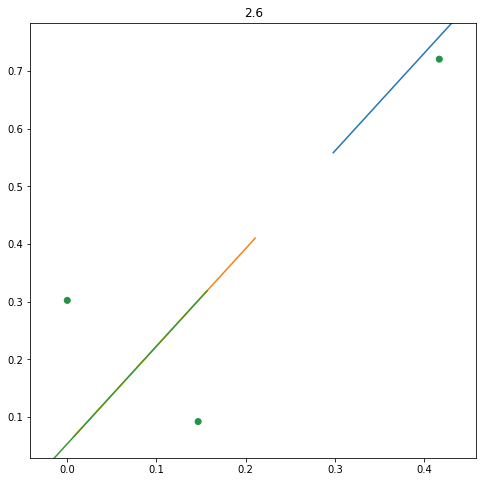

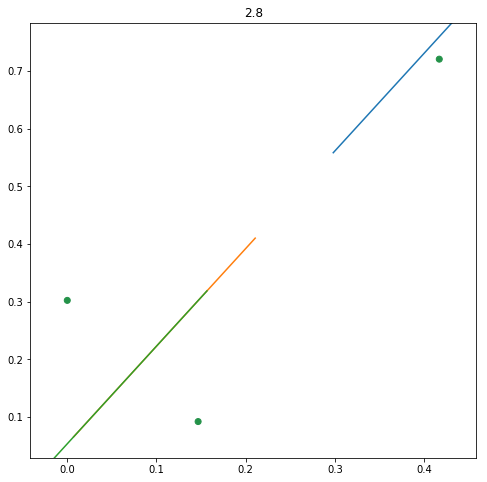

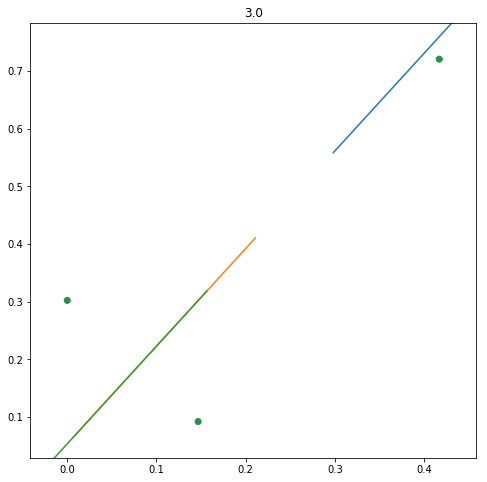

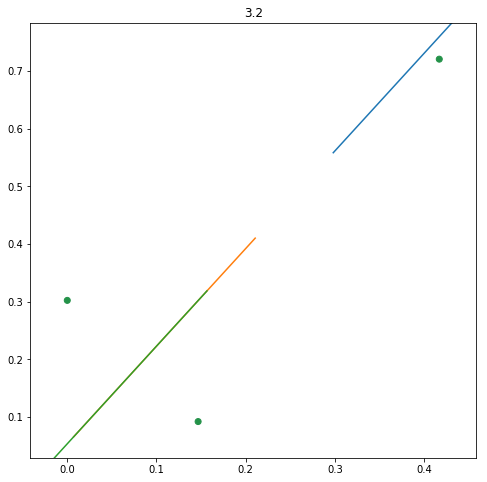

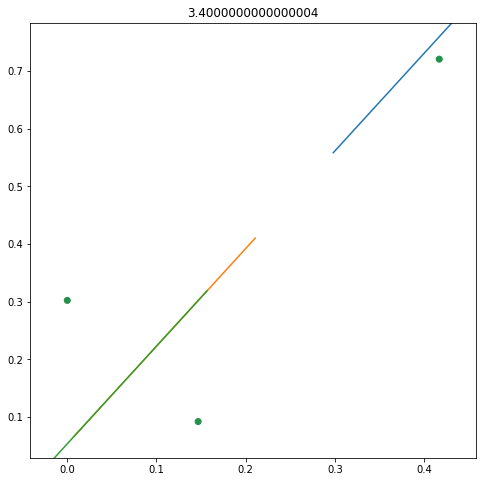

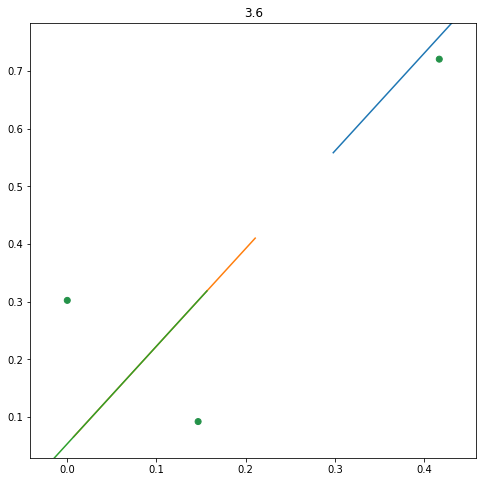

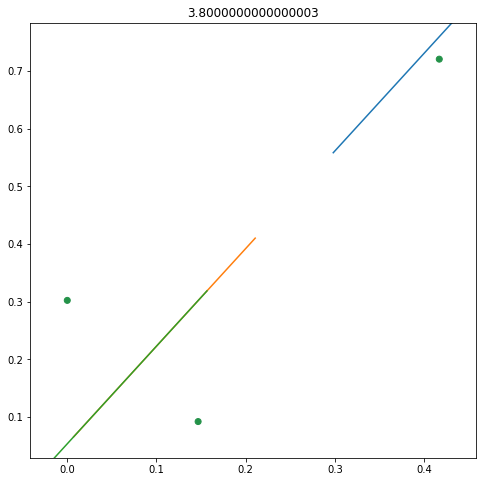

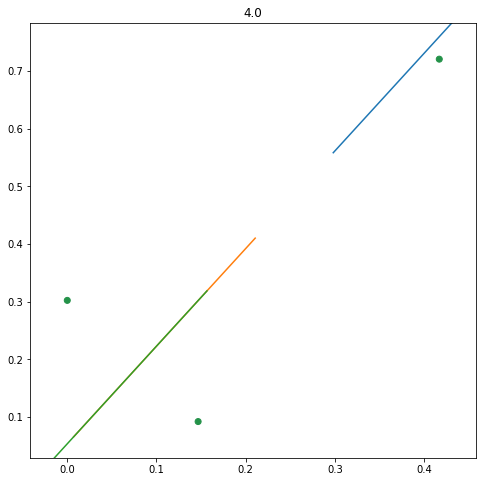

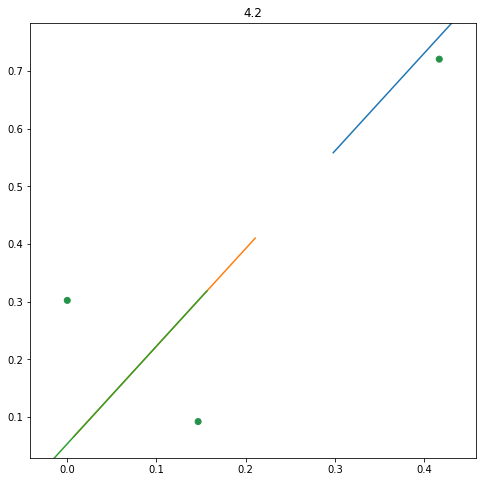

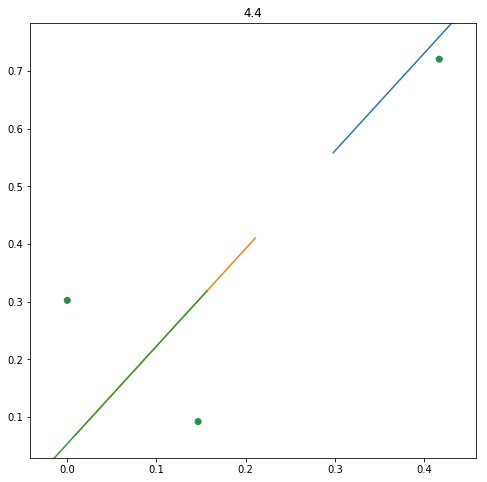

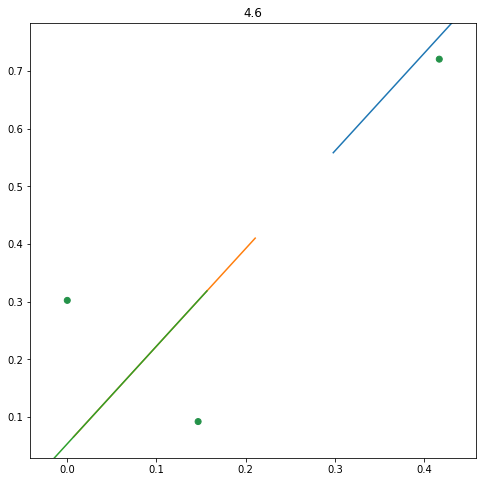

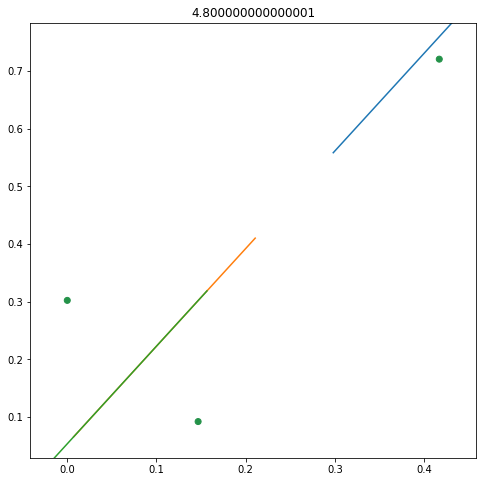

In [10]:
fig_dir_lines = os.path.join(project_dir, "odr_various_bandwidth")
make_local_odr_lines_animation(linear_models, small_data, c, fig_dir_lines, 
    np.concatenate((np.linspace(0.03,0.3,20,endpoint=False), 
                    np.linspace(0.3,1,20,endpoint=False), 
                    np.linspace(1,5,20,endpoint=False))),
                               kernel=KERNEL
)

In [ ]:
def make_local_odr_projections_animation(linear_models, data, c, pth, ks, range_pct=0.1, grid_steps=100, kernel=lm.TriCubeKernel):
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=len(ks), tag="odr_projections_k", running_avg_length=10)
    min_nm, max_nm = np.min(data, axis=0), np.max(data, axis=0)
    nm_range = max_nm - min_nm
    how_much_to_include_outside_range =  range_pct*nm_range
    nm_ranges = np.stack((min_nm - how_much_to_include_outside_range, max_nm + how_much_to_include_outside_range))
    
    grid = get_global_grid(data, outside_range_pct=range_pct, n_steps=grid_steps)
    gridder = Grid2Vec().fit(grid)
    grid = gridder.transform(grid)
    projections = np.zeros(grid.shape)
    
    os.makedirs(pth, exist_ok=1)
    for k in ks:
        with timelog:
            kernel_kb = kernel(bandwidth="knn")        
            figure = plt.figure()
            linear_params_grid = linear_models.transform(grid, k=k, weighted=True, distance_transform=kernel_kb, neighbor_beta0s=True)
            for i in range(grid.shape[0]):
                projections[i] = linear_project(grid[i], linear_params_grid[i])
            plt.quiver(grid[:,0], grid[:,1], projections[:,0], projections[:,1], scale=10)
            plt.scatter(data[:,0], data[:,1],c=cmap(c))
            plt.title("k {:05d}".format(k))
            plt.xlim(nm_ranges[:,0])
            plt.ylim(nm_ranges[:,1])
            plt.savefig(os.path.join(pth, "k_{:05d}.png".format(k)))    
    

In [ ]:
fig_dir_projections_k = os.path.join(project_dir, "odr_projections_various_k")
make_local_odr_projections_animation(linear_models, small_data, c, fig_dir_projections_k,
                                     np.array([2,3]),
                                     kernel=KERNEL
                                    )

In [11]:
def make_local_odr_projections_animation(linear_models, data, c, pth, bandwidths, range_pct=0.1, grid_steps=100, kernel=lm.TriCubeKernel):
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=len(bandwidths), tag="odr_projections", running_avg_length=10)
    min_nm, max_nm = np.min(data, axis=0), np.max(data, axis=0)
    nm_range = max_nm - min_nm
    how_much_to_include_outside_range =  range_pct*nm_range
    nm_ranges = np.stack((min_nm - how_much_to_include_outside_range, max_nm + how_much_to_include_outside_range))
    
    grid = get_global_grid(data, outside_range_pct=range_pct, n_steps=grid_steps)
    gridder = Grid2Vec().fit(grid)
    grid = gridder.transform(grid)
    projections = np.zeros(grid.shape)
    
    os.makedirs(pth, exist_ok=1)
    for bandwidth in bandwidths:
        with timelog:
            kernel_cb = kernel(bandwidth=bandwidth)        
            figure = plt.figure()
            linear_params_grid = linear_models.transform(grid, r=kernel_cb.support_radius(), weighted=True, distance_transform=kernel_cb, neighbor_beta0s=True)
            for i in range(grid.shape[0]):
                projections[i] = linear_project(grid[i], linear_params_grid[i])
            plt.quiver(grid[:,0], grid[:,1], projections[:,0], projections[:,1], scale=10)
            plt.scatter(data[:,0], data[:,1],c=cmap(c))
            plt.title(str(bandwidth))
            plt.xlim(nm_ranges[:,0])
            plt.ylim(nm_ranges[:,1])
            plt.savefig(os.path.join(pth, "bandwidth_{:010.5f}.png".format(bandwidth)))

In [ ]:
fig_dir_projections = os.path.join(project_dir, "odr_projections_various_bandwidth")
make_local_odr_projections_animation(linear_models, small_data, c, fig_dir_projections,
                                     np.concatenate((np.linspace(0.03,0.3,20,endpoint=False), 
                                                     np.linspace(0.3,1,20,endpoint=False), 
                                                     np.linspace(1,5,20,endpoint=False))),
                                     kernel=KERNEL
                                    )


In [ ]:
imgs2video(os.path.join(fig_dir_lines,"*.png") 
           os.path.join(fig_dir_lines,"out.mp4", 10)
imgs2video(os.path.join(fig_dir_projections,"*.png"), 
           os.path.join(fig_dir_projections,"out.mp4", 10)

In [ ]:
from IPython.display import Markdown as md
def video_html(src):
    return '''<video controls src="{}" type="video/mp4"/>'''.format(src)
md(video_html(os.path.join(fig_dir_lines, "out.mp4")) +
   video_html(os.path.join(fig_dir_projections, "out.mp4")))

In [ ]:
def make_odr_iterprojections_animation(linear_models, data, c, pth, bandwidth, range_pct=0.1, grid_steps=100, iterations=100, kernel=lm.TriCubeKernel):
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=len(bandwidths), tag="odr_iterprojections", running_avg_length=10)
    min_nm, max_nm = np.min(data, axis=0), np.max(data, axis=0)
    nm_range = max_nm - min_nm
    how_much_to_include_outside_range =  range_pct*nm_range
    nm_ranges = np.stack((min_nm - how_much_to_include_outside_range, max_nm + how_much_to_include_outside_range))
    
    grid = get_global_grid(small_data, outside_range_pct=range_pct, n_steps=grid_steps)
    gridder = Grid2Vec()
    grid = gridder.fit_transform(grid)
    projections = grid.copy()
    kernel_cb = kernel(bandwidth=bandwidth)

    os.makedirs(pth, exist_ok=1)
    for i in range(iterations):
        with timelog:
            figure = plt.figure()
            plt.scatter(data[:,0], data[:,1],c=cmap(c))
            plt.scatter(projections[:,0], projections[:,1],c='r',s=0.1)
            plt.title("iteration_{:05d}".format(i))
            plt.xlim(nm_ranges[:,0])
            plt.ylim(nm_ranges[:,1])
            plt.savefig(os.path.join(pth, "iteration_{:05d}.png".format(i)))
            linear_params_grid = linear_models.transform(projections, r=kernel_cb.support_radius(), weighted=True, distance_transform=kernel_cb, neighbor_beta0s=True)
            err_pts = np.any(np.isnan(linear_params_grid), axis=1)
            logger.info("linear odr undefined at {} pts".format(err_pts.sum()))
            good_pts = np.logical_not(err_pts)
            projections, linear_params_grid = projections[good_pts], linear_params_grid[good_pts]
            projections += linear_project_vectorized(projections, linear_params_grid)

In [ ]:
BANDWIDTH = 0.37
N_STEPS = 300
fig_dir = os.path.join(project_dir, "odr_projections_iteration_b{:.4f}_g{:05d}".format(BANDWIDTH,N_STEPS))
make_odr_iterprojections_animation(linear_models, small_data, c, fig_dir, BANDWIDTH, grid_steps=N_STEPS, kernel=KERNEL)

In [ ]:
import scipy.spatial.distance
import scipy.optimize
def covmatrix_eig(pt, data, bandwidth):
    pt = pt.reshape((1,-1))
    kernel_cb = lm.TriCubeKernel(bandwidth=bandwidth)
    distances = scipy.spatial.distance.cdist(pt, data)
    covmat = np.cov(data, aweights=kernel_cb(distances))
    eigenvalues, eigenvectors = np.linalg.eig(covmat)
    return eigenvalues, eigenvectors
def covmatrix_eig_distance(pt, data, bandwidth, which_eigenvector=1):
    eigenvalues, eigenvectors = covmatrix_eig(pt, data, bandwidth)
    sorted_eigenvalues = np.sort(eigenvalues)
    return (sorted_eigenvalues[which_eigenvector] - sorted_eigenvalues[which_eigenvector+1])**2
def find_equal_covmatrix_eig(data, bandwidth, which_eigenvector=1):
    res = scipy.optimize.minimize(covmatrix_eig_distance, np.mean(data, axis=0), args=(data, bandwidth, which_eigenvector))
    print(res.success)
    return res.x
pt = find_equal_covmatrix_eig(small_data, BANDWIDTH)
print(pt)
print(covmatrix_eig(pt, small_data, BANDWIDTH))
    
    
    
